In [1]:
import gc
from datetime import datetime, timedelta,date
import warnings
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection,johnson_lindenstrauss_min_dim
from sklearn.decomposition import PCA, FastICA,NMF,LatentDirichletAllocation,IncrementalPCA,MiniBatchSparsePCA
from sklearn.decomposition import TruncatedSVD,FactorAnalysis,KernelPCA

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold, KFold

from scipy.stats import ks_2samp
import tqdm

#settings
warnings.filterwarnings('ignore')
np.random.seed(2018)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',130)

### Utility Function

In [2]:
def get_prefix(group_col, target_col, prefix=None):
    if isinstance(group_col, list) is True:
        g = '_'.join(group_col)
    else:
        g = group_col
    if isinstance(target_col, list) is True:
        t = '_'.join(target_col)
    else:
        t = target_col
    if prefix is not None:
        return prefix + '_' + g + '_' + t
    return g + '_' + t
    
def groupby_helper(df, group_col, target_col, agg_method, prefix_param=None):
    try:
        prefix = get_prefix(group_col, target_col, prefix_param)
        print(group_col, target_col, agg_method)
        group_df = df.groupby(group_col)[target_col].agg(agg_method)
        group_df.columns = ['{}_{}'.format(prefix, m) for m in agg_method]
    except BaseException as e:
        print(e)
    return group_df.reset_index()

In [3]:
def create_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

### 데이터 Load

In [4]:
historical_trans_df = pd.read_csv('input/historical_transactions.csv')
new_merchant_trans_df = pd.read_csv('input/new_merchant_transactions.csv')
merchant_df = pd.read_csv('input/merchants.csv')
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

### 기본 전처리

In [5]:
def get_hist_default_prorcessing(df):
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime(2012,4,1) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['reference_date'] = (df['year']+(df['month'] - df['month_lag'])//12)*100 + (((df['month'] - df['month_lag'])%12) + 1)*1
    return df

In [6]:
historical_trans_df = get_hist_default_prorcessing(historical_trans_df)
new_merchant_trans_df = get_hist_default_prorcessing(new_merchant_trans_df)

In [7]:
historical_trans_df = historical_trans_df.sort_values('purchase_date')
new_merchant_trans_df = new_merchant_trans_df.sort_values('purchase_date')

In [8]:
#historical_trans_df = pd.get_dummies(historical_trans_df, columns=['category_2', 'category_3'])
#new_merchant_trans_df = pd.get_dummies(new_merchant_trans_df, columns=['category_2', 'category_3'])

In [8]:
authorized_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 1]
historical_transactions = historical_trans_df[historical_trans_df['authorized_flag'] == 0]

### Feature Engineering

In [9]:
all_df = pd.concat([train_df,test_df])

In [10]:
historical_trans_df.loc[historical_trans_df['installments']==999,'installments_999'] = 1
new_merchant_trans_df.loc[new_merchant_trans_df['installments']==999,'installments_999'] = 1

historical_trans_df.loc[historical_trans_df['installments']==999,'installments'] = -1
new_merchant_trans_df.loc[new_merchant_trans_df['installments']==999,'installments_999'] = -1

In [11]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'purchase_amount',['count','mean'])
group_df['card_id_month_lag_purchase_amount_count'] = group_df['card_id_month_lag_purchase_amount_count']/(1-group_df['month_lag'])
group_df['card_id_month_lag_purchase_amount_mean'] = group_df['card_id_month_lag_purchase_amount_mean']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_count',['sum','mean','std'])
mean_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_purchase_amount_mean',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')
all_df = all_df.merge(mean_df, on=['card_id'], how='left')

['card_id', 'month_lag'] purchase_amount ['count', 'mean']
['card_id'] card_id_month_lag_purchase_amount_count ['sum', 'mean', 'std']
['card_id'] card_id_month_lag_purchase_amount_mean ['sum', 'mean', 'std']


In [12]:
group_df = groupby_helper(historical_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'month',['nunique','max','min','mean','std'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'month',['nunique','max','min','mean'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean', 'std']
['card_id'] month ['nunique', 'max', 'min', 'mean']


98

In [13]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'merchant_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'merchant_category_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'subsector_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'subsector_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(historical_transactions,['card_id'], 'state_id',['nunique'],'auth_0')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
group_df = groupby_helper(authorized_transactions,['card_id'], 'state_id',['nunique'],'auth_1')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
del group_df
gc.collect()

['card_id'] merchant_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']
['card_id'] state_id ['nunique']


70

In [14]:
group_df = groupby_helper(historical_trans_df,['card_id'], 'city_id',['nunique'])
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'merchant_category_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'subsector_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'state_id',['nunique'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

['card_id'] city_id ['nunique']
['card_id'] merchant_category_id ['nunique']
['card_id'] subsector_id ['nunique']
['card_id'] state_id ['nunique']


In [15]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']
    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [16]:
new_columns = create_new_columns('hist',aggs)
historical_trans_group_df = historical_trans_df.groupby('card_id').agg(aggs)
historical_trans_group_df.columns = new_columns
historical_trans_group_df.reset_index(drop=False,inplace=True)
historical_trans_group_df['hist_purchase_date_diff'] = (historical_trans_group_df['hist_purchase_date_max'] - historical_trans_group_df['hist_purchase_date_min']).dt.days
historical_trans_group_df['hist_purchase_date_average'] = historical_trans_group_df['hist_purchase_date_diff']/historical_trans_group_df['hist_card_id_size']
historical_trans_group_df['hist_purchase_date_uptonow'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_max']).dt.days
historical_trans_group_df['hist_purchase_date_uptomin'] = (datetime(2012,4,1) - historical_trans_group_df['hist_purchase_date_min']).dt.days
all_df = all_df.merge(historical_trans_group_df, on=['card_id'], how='left')

In [17]:
aggs = {}

for col in ['hour', 'weekofyear', 'dayofweek', 'year']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

    
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean', 'max', 'min', 'var']
aggs['weekend'] = ['sum', 'mean', 'min', 'max']
aggs['category_1'] = ['sum', 'mean', 'min', 'max']
#aggs['authorized_flag'] = ['sum', 'mean', 'min', 'max']
#aggs['category_2'] = ['sum', 'mean', 'min', 'max']
#aggs['category_3'] = ['sum', 'mean', 'min', 'max']
aggs['card_id'] = ['size']
aggs['reference_date'] = ['median']

In [18]:
new_columns = create_new_columns('new_hist',aggs)
new_merchant_trans_group_df = new_merchant_trans_df.groupby('card_id').agg(aggs)
new_merchant_trans_group_df.columns = new_columns
new_merchant_trans_group_df.reset_index(drop=False,inplace=True)
new_merchant_trans_group_df['new_hist_purchase_date_diff'] = (new_merchant_trans_group_df['new_hist_purchase_date_max'] - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_average'] = new_merchant_trans_group_df['new_hist_purchase_date_diff']/new_merchant_trans_group_df['new_hist_card_id_size']
new_merchant_trans_group_df['new_hist_purchase_date_uptonow'] = (datetime(2012,4,1) - new_merchant_trans_group_df['new_hist_purchase_date_max']).dt.days
new_merchant_trans_group_df['new_hist_purchase_date_uptomin'] = (datetime(2012,4,1) - new_merchant_trans_group_df['new_hist_purchase_date_min']).dt.days
#merge with train, test
all_df = all_df.merge(new_merchant_trans_group_df, on=['card_id'], how='left')

In [19]:
fill_new_hist_size = pd.read_csv('input/fill_new_hist_size_20190210_132027_cv3.397927.csv')
new_hist_card_id_size = pd.concat([all_df.loc[all_df['new_hist_card_id_size'].notnull(),['card_id','new_hist_card_id_size']],fill_new_hist_size])
all_df = all_df.merge(new_hist_card_id_size, on='card_id',how='left')
all_df['new_hist_card_id_size_x'] = all_df['new_hist_card_id_size_y']
del all_df['new_hist_card_id_size_y']
all_df.rename(columns={'new_hist_card_id_size_x':'new_hist_card_id_size'},inplace=True)

In [20]:
fill_new_hist_date_max = pd.read_csv('input/fill_new_hist_card_id_purchase_date_max_20190210_140257_cv12.776013.csv')
new_hist_purchase_date_max = pd.concat([all_df.loc[all_df['new_hist_purchase_date_max'].notnull(),['card_id','new_hist_purchase_date_max']],fill_new_hist_date_max])
all_df = all_df.merge(new_hist_purchase_date_max, on='card_id',how='left')
all_df['new_hist_purchase_date_max_x'] = all_df['new_hist_purchase_date_max_y']
del all_df['new_hist_purchase_date_max_y']
all_df.rename(columns={'new_hist_purchase_date_max_x':'new_hist_purchase_date_max'},inplace=True)

In [21]:
fill_new_hist_date_min = pd.read_csv('input/fill_new_hist_card_id_purchase_date_min_20190210_142523_cv11.764345.csv')
new_hist_purchase_date_min = pd.concat([all_df.loc[all_df['new_hist_purchase_date_min'].notnull(),['card_id','new_hist_purchase_date_min']],fill_new_hist_date_min])
all_df = all_df.merge(new_hist_purchase_date_min, on='card_id',how='left')
all_df['new_hist_purchase_date_min_x'] = all_df['new_hist_purchase_date_min_y']
del all_df['new_hist_purchase_date_min_y']
all_df.rename(columns={'new_hist_purchase_date_min_x':'new_hist_purchase_date_min'},inplace=True)

In [22]:
all_df['new_hist_purchase_date_min'] = pd.to_datetime(all_df['new_hist_purchase_date_min'])
all_df['new_hist_purchase_date_max'] = pd.to_datetime(all_df['new_hist_purchase_date_max'])

In [23]:
def get_train_default_prorcessing(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    #df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['year'] = df['first_active_month'].dt.year
    
    #df['elapsed_time'] = (datetime(2018, 2, 1).date() - df['first_active_month'].dt.date).dt.days
    df['elapsed_time'] = (datetime(2019,1, 20) - df['first_active_month']).dt.days
    #df['after_big_event'] = (datetime(2012,4, 1) - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    
    df['year_month'] = df['year']*100 + df['month']
    df['hist_diff_reference_date_first'] = 12*(df['hist_reference_date_median']//100 - df['year_month']//100) + (df['hist_reference_date_median']%100 - df['year_month']%100)
    df['hist_diff_reference_date_last'] = 12*(df['hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['new_hist_diff_reference_date_first'] = 12*(df['new_hist_reference_date_median']//100 - df['year_month']//100) + (df['new_hist_reference_date_median']%100 - df['year_month']%100)
    df['new_hist_diff_reference_date_last'] = 12*(df['new_hist_purchase_date_max'].dt.year - df['year_month']//100) + (df['new_hist_purchase_date_max'].dt.month - df['year_month']%100)
    
    df['hist_diff_first_last'] = df['hist_diff_reference_date_first'] - df['hist_diff_reference_date_last'] 
    df['new_hist_diff_first_last'] = df['new_hist_diff_reference_date_first'] - df['new_hist_diff_reference_date_last'] 
    df['diff_new_hist_date_min_max'] = (df['new_hist_purchase_date_min'] - df['hist_purchase_date_max']).dt.days
    df['diff_new_hist_date_max_max'] = (df['new_hist_purchase_date_max'] - df['hist_purchase_date_max']).dt.days    
    
    
    df['hist_flag_ratio'] = df['hist_authorized_flag_sum'] / df['hist_card_id_size']
    #df['new_flag_ratio'] = df['new_hist_authorized_flag_sum'] / df['new_hist_card_id_size']
    #df['new_hist_flag_ratio'] = 1/(1+df['hist_flag_ratio'])
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_ratio'] = df['new_hist_card_id_size']/df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_hist_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_hist_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_hist_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_hist_purchase_amount_sum']/df['hist_purchase_amount_sum']
    
    df['month_diff_mean'] = df['new_hist_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_hist_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_hist_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_hist_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_hist_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_hist_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_hist_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_hist_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_hist_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_hist_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    
    #df['duration_mean'] = df['new_hist_duration_mean']+df['hist_duration_mean']
    #df['duration_min'] = df['new_hist_duration_min']+df['hist_duration_min']
    #df['duration_max'] = df['new_hist_duration_max']+df['hist_duration_max']
    #df['amount_month_ratio_mean']=df['new_hist_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    #df['amount_month_ratio_min']=df['new_hist_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    #df['amount_month_ratio_max']=df['new_hist_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_hist_card_id_size'] * df['new_hist_purchase_amount_sum'] / df['new_hist_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_size'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    
    del df['year']
    del df['year_month']
    del df['new_hist_reference_date_median']
    
    return df

In [24]:
all_df = get_train_default_prorcessing(all_df)

In [25]:
group_df = groupby_helper(new_merchant_trans_df,['card_id'], 'authorized_flag',['sum'],'new_hist')
all_df = all_df.merge(group_df, on=['card_id'], how='left')
all_df['new_flag_ratio'] = all_df['new_hist_card_id_authorized_flag_sum'] / all_df['new_hist_card_id_size']
all_df['new_hist_flag_ratio'] = all_df['new_flag_ratio']/(all_df['new_flag_ratio']+all_df['hist_flag_ratio'])
del all_df['new_hist_card_id_authorized_flag_sum']

['card_id'] authorized_flag ['sum']


In [26]:
all_df['feature123'] = all_df['feature_1'].astype(str) +'_'+all_df['feature_2'].astype(str)+'_'+all_df['feature_3'].astype(str)
all_df['feature123'] = pd.factorize(all_df['feature123'])[0]

In [27]:
group_df = groupby_helper(historical_trans_df,['card_id','month_lag'], 'subsector_id',['nunique'])
group_df['card_id_month_lag_subsector_id_nunique'] = group_df['card_id_month_lag_subsector_id_nunique']/(1-group_df['month_lag'])
del group_df['month_lag']

count_df = groupby_helper(group_df,['card_id'], 'card_id_month_lag_subsector_id_nunique',['sum','mean','std'])

all_df = all_df.merge(count_df, on=['card_id'], how='left')

['card_id', 'month_lag'] subsector_id ['nunique']
['card_id'] card_id_month_lag_subsector_id_nunique ['sum', 'mean', 'std']


In [28]:
group_df_mode = pd.read_csv('input/subsector_id_mode.csv')
group_df = groupby_helper(group_df_mode.reset_index(),'card_id', 'subsector_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id subsector_id ['nunique']


In [29]:
group_df_mode_mci = pd.read_csv('input/merchant_category_id_mode.csv')
group_df = groupby_helper(group_df_mode_mci.reset_index(),'card_id', 'merchant_category_id',['nunique'],'mode')
all_df = all_df.merge(group_df, on=['card_id'], how='left')

card_id merchant_category_id ['nunique']


In [30]:
all_df['feature123_frequency_encoding']= all_df['feature123'].map(all_df['feature123'].value_counts()/all_df.shape[0])

firstactive month보다 작거나 같은 달의 거래횟수 / 전체 거래횟수

In [31]:
historical_trans_df =historical_trans_df.merge(all_df[['card_id','first_active_month','target','feature123']], on='card_id',how='left')
historical_trans_df['ym'] = historical_trans_df['purchase_date'].dt.year*100 + historical_trans_df['purchase_date'].dt.month
historical_trans_df['first_active_month_ym'] = historical_trans_df['first_active_month'].dt.year*100 + historical_trans_df['first_active_month'].dt.month
historical_trans_df['is_smaller_firstactive'] = 0
historical_trans_df.loc[historical_trans_df['ym']<=historical_trans_df['first_active_month_ym'],'is_smaller_firstactive'] = 1
group_df = groupby_helper(historical_trans_df,'card_id', 'is_smaller_firstactive',['sum'])
temp = groupby_helper(historical_trans_df,'card_id', 'card_id',['size'])
group_df = group_df.merge(temp, on='card_id', how='left')
group_df['before_firstactive_purchase_ratio']=group_df['card_id_is_smaller_firstactive_sum'] /group_df['card_id_card_id_size']
all_df = all_df.merge(group_df[['card_id','before_firstactive_purchase_ratio']], on=['card_id'], how='left')

card_id is_smaller_firstactive ['sum']
card_id card_id ['size']


In [32]:
fill_new_hist_amount = pd.read_csv('input/fill_new_hist_purchase_amount_mean_20190210_153454_cv0.159328.csv')
new_hist_purchase_amount_mean = pd.concat([all_df.loc[all_df['new_hist_purchase_amount_mean'].notnull(),['card_id','new_hist_purchase_amount_mean']],fill_new_hist_amount])
all_df = all_df.merge(new_hist_purchase_amount_mean, on='card_id',how='left')
all_df['new_hist_purchase_amount_mean_x'] = all_df['new_hist_purchase_amount_mean_y']
del all_df['new_hist_purchase_amount_mean_y']
all_df.rename(columns={'new_hist_purchase_amount_mean_x':'new_hist_purchase_amount_mean'},inplace=True)

# Single Model

In [33]:
for col in all_df.columns:
    if col.find('weekend') !=-1:
        print(col)
        del all_df[col]

hist_weekend_sum
hist_weekend_mean
hist_weekend_min
hist_weekend_max
new_hist_weekend_sum
new_hist_weekend_mean
new_hist_weekend_min
new_hist_weekend_max


아래 코드는 사용하면 안됨

In [68]:
for col in all_df.columns:
    if col.find('new_hist_predict_sum') !=-1:
        print(col)
        del all_df[col]

new_hist_predict_sum


In [34]:
for col in all_df.columns:
    if all_df[col].nunique() == 1:
        print(col)
        del all_df[col]

hist_year_min
hist_authorized_flag_max
new_flag_ratio


In [35]:
for col in all_df.columns:
    if col in ['new_hist_year_max', 'hist_year_max', 'hist_authorized_flag_min',
       'new_hist_year_min','new_hist_diff_first_last', 'hist_category_1_min',
       'new_hist_category_1_max', 'hist_category_1_max']:
        print(col)
        del all_df[col]

hist_year_max
hist_category_1_min
hist_category_1_max
hist_authorized_flag_min
new_hist_year_min
new_hist_year_max
new_hist_category_1_max
new_hist_diff_first_last


In [36]:
print(all_df.shape)
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]

print(train_df.shape)
print(test_df.shape)
#train_df['target'] = np.power(2,train_df['target'])-1e-10

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

(325540, 173)
(201917, 173)
(123623, 173)
['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [37]:
train = train_df.copy()
target = train['target']
del train['target']

In [38]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

feature_importance_df = pd.DataFrame()
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
cv_score_list = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    cv_score = np.sqrt(mean_squared_error(oof[val_idx], target.iloc[val_idx]))
    cv_score_list.append(cv_score)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
print(cv_score_list)
print(np.std(cv_score_list))
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60915	valid_1's rmse: 3.68825
[200]	training's rmse: 3.52271	valid_1's rmse: 3.66305
[300]	training's rmse: 3.46832	valid_1's rmse: 3.65404
[400]	training's rmse: 3.4284	valid_1's rmse: 3.65024
[500]	training's rmse: 3.3948	valid_1's rmse: 3.64786
[600]	training's rmse: 3.36388	valid_1's rmse: 3.64638
[700]	training's rmse: 3.33611	valid_1's rmse: 3.64593
[800]	training's rmse: 3.30997	valid_1's rmse: 3.64573
Early stopping, best iteration is:
[767]	training's rmse: 3.31895	valid_1's rmse: 3.64558
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.60528	valid_1's rmse: 3.70424
[200]	training's rmse: 3.51676	valid_1's rmse: 3.68255
[300]	training's rmse: 3.46227	valid_1's rmse: 3.67435
[400]	training's rmse: 3.42142	valid_1's rmse: 3.67047
[500]	training's rmse: 3.38696	valid_1's rmse: 3.66769
[600]	training's rmse: 3.3562	valid_1's rmse: 3.66644
Ear

3.642949234454408
[3.650372093530145, 3.6654924308558225, 3.6363536724363317, 3.6116579841044336, 3.683739370140129, 3.599946129541865, 3.6482507919569693, 3.6219036348081093, 3.6679752038284614]
0.026238823717363524
<br><br>
3.6428863718087587
[3.6522792332250327, 3.665450676045149, 3.636531749195274, 3.6140651658687664, 3.6852817839701943, 3.5979954896074053, 3.646315507786246, 3.619488332145068, 3.667682002994765]
0.026780884869751578


3.6428146664055
[3.6501135678910366, 3.664859009681865, 3.63493765968693, 3.6128540227141923, 3.685697657686427, 3.5996142490993166, 3.649337560843338, 3.6153675492689836, 3.671612040623591]
0.02754637440509606

3.642503843704918
[3.64757341534984, 3.663428698392028, 3.63447519800449, 3.616714271030949, 3.681904119176495, 3.6010349183991646, 3.6494781818376794, 3.6139121267497876, 3.6731517506764777]
0.02639550490504317

3.6425160908510565
[3.6488564856876575, 3.6688472934843923, 3.631136078642995, 3.6085547967228577, 3.6870112040323146, 3.6007539214264095, 3.651298834208597, 3.6150517267893227, 3.6701262870971574]
0.028546139610707896

3.642831909409755
[3.6483118994300394, 3.668117392778045, 3.637584552007164, 3.614629343104113, 3.6835262056884464, 3.595595704820776, 3.6523621200675214, 3.6181163473641895, 3.6663317549971293]
0.027148612642736943

3.6405307468865984
[3.6455820900379687, 3.666180022374183, 3.6349562435972667, 3.613217296402693, 3.681676799693321, 3.5959030909405985, 3.6476911094231648, 3.6149825458283398, 3.66370903435235]
0.026638015923934003

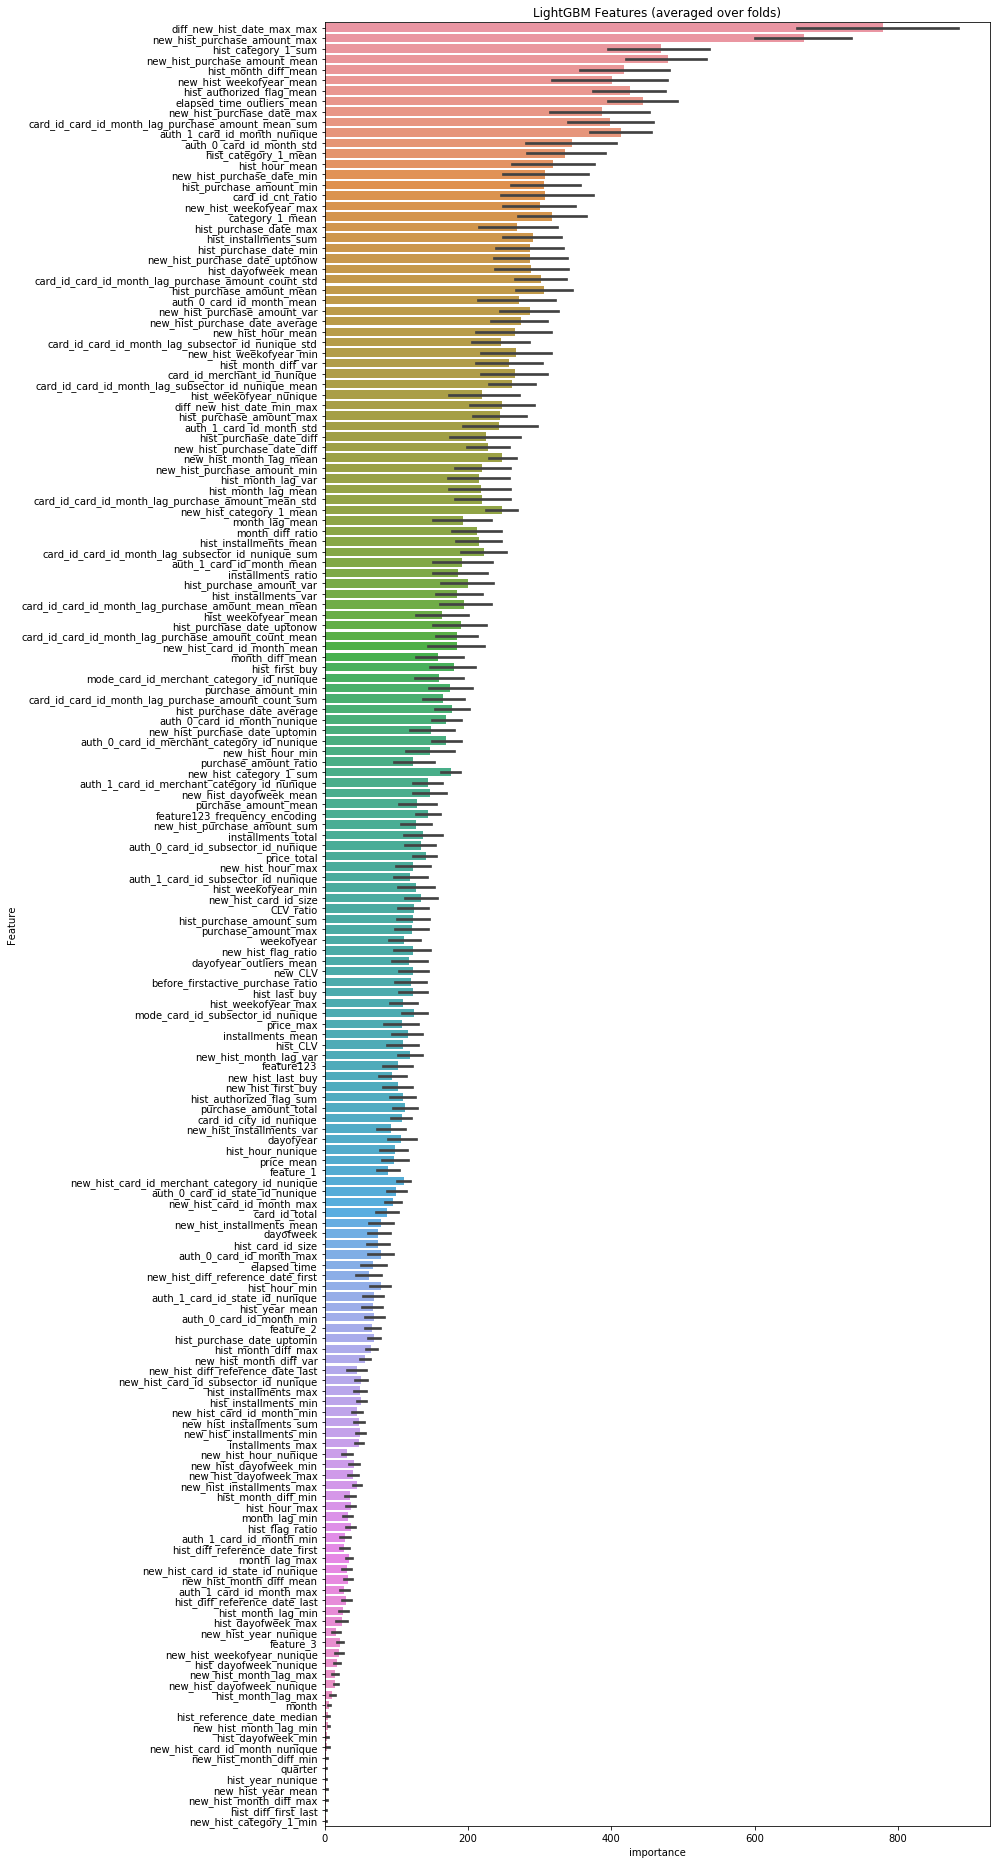

In [39]:
filename = '{}_cv{:.6f}'.format(datetime.now().strftime('%Y%m%d_%H%M%S'), cv_score)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('fi/{}_lgbm_importances.png'.format(filename))

In [40]:
feature_importance_df.groupby('Feature')['importance'].sum().reset_index().sort_values('importance')

,Feature,importance
54,hist_diff_first_last,9
117,new_hist_category_1_min,14
170,quarter,15
94,hist_year_nunique,15
139,new_hist_month_diff_min,17
160,new_hist_year_mean,17
137,new_hist_month_diff_max,18
52,hist_dayofweek_min,26
112,new_hist_card_id_month_nunique,36
88,hist_reference_date_median,44


In [41]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df['target'] = predictions
#sub_df.loc[sub_df['target']<-9,'target'] = -33.21928095
sub_df.to_csv("output/submission_{}.csv".format(filename), index=False)

# Post Processing

### without Outlier

In [42]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
train_df = train_df.loc[train_df['target']>-30]
"""
train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_df = train_df.loc[train_df['target']>-30]
"""
train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers',
                                                          
                                                          'before_firstactive_purchase_ratio']]
train_columns

['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [43]:
train = train_df.copy()
target = train['target']
del train['target']

In [44]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 12,
         "seed": 6}

#prepare fit model with cross-validation
np.random.seed(2019)

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    strLog = "fold {}".format(fold_+1)
    print(strLog)
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv_score = np.sqrt(mean_squared_error(oof, target))
print(cv_score)
withoutoutlier_predictions = predictions.copy()

fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.58815	valid_1's rmse: 1.58059
[200]	training's rmse: 1.56068	valid_1's rmse: 1.5577
[300]	training's rmse: 1.54689	valid_1's rmse: 1.54897
[400]	training's rmse: 1.53712	valid_1's rmse: 1.5451
[500]	training's rmse: 1.52909	valid_1's rmse: 1.54297
[600]	training's rmse: 1.5222	valid_1's rmse: 1.54173
[700]	training's rmse: 1.51587	valid_1's rmse: 1.54112
[800]	training's rmse: 1.51	valid_1's rmse: 1.5404
[900]	training's rmse: 1.50429	valid_1's rmse: 1.54014
[1000]	training's rmse: 1.49884	valid_1's rmse: 1.54007
[1100]	training's rmse: 1.49359	valid_1's rmse: 1.53987
[1200]	training's rmse: 1.4884	valid_1's rmse: 1.53974
[1300]	training's rmse: 1.48323	valid_1's rmse: 1.53961
[1400]	training's rmse: 1.47841	valid_1's rmse: 1.53947
Early stopping, best iteration is:
[1399]	training's rmse: 1.47845	valid_1's rmse: 1.53946
fold 2
Training until validation scores don't improve for 100 rounds.
[1

[200]	training's rmse: 1.55768	valid_1's rmse: 1.58226
[300]	training's rmse: 1.54358	valid_1's rmse: 1.57472
[400]	training's rmse: 1.53373	valid_1's rmse: 1.57084
[500]	training's rmse: 1.52574	valid_1's rmse: 1.56883
[600]	training's rmse: 1.51875	valid_1's rmse: 1.5678
[700]	training's rmse: 1.51244	valid_1's rmse: 1.56702
[800]	training's rmse: 1.50643	valid_1's rmse: 1.56666
[900]	training's rmse: 1.50084	valid_1's rmse: 1.56632
[1000]	training's rmse: 1.49538	valid_1's rmse: 1.5661
[1100]	training's rmse: 1.49004	valid_1's rmse: 1.56594
[1200]	training's rmse: 1.48489	valid_1's rmse: 1.56566
[1300]	training's rmse: 1.47992	valid_1's rmse: 1.56549
[1400]	training's rmse: 1.47495	valid_1's rmse: 1.5654
Early stopping, best iteration is:
[1374]	training's rmse: 1.47623	valid_1's rmse: 1.56534
1.5541206317249239


1.5541206116854704

In [45]:
model_without_outliers = pd.DataFrame({"card_id":test_df["card_id"].values})
model_without_outliers["target"] = withoutoutlier_predictions

### outlier

In [76]:
train_df = all_df.loc[all_df['target'].notnull()]
test_df = all_df.loc[all_df['target'].isnull()]
#train_df = train_df.loc[train_df['target']>-30]

train_df['outliers'] = 0
train_df.loc[train_df['target'] < -30, 'outliers'] = 1
train_df['outliers'].value_counts()

for f in ['feature_1','feature_2','feature_3']:
    order_label = train_df.groupby([f])['outliers'].mean()
    train_df[f] = train_df[f].map(order_label)
    test_df[f] = test_df[f].map(order_label)

group_df = groupby_helper(train_df,['dayofyear'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['dayofyear'], how='left')
test_df = test_df.merge(group_df, on=['dayofyear'], how='left')

group_df = groupby_helper(train_df,['elapsed_time'], 'outliers',['mean'])
train_df = train_df.merge(group_df, on=['elapsed_time'], how='left')
test_df = test_df.merge(group_df, on=['elapsed_time'], how='left')

train_columns = [c for c in train_df.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns

['dayofyear'] outliers ['mean']
['elapsed_time'] outliers ['mean']


['feature_1',
 'feature_2',
 'feature_3',
 'card_id_card_id_month_lag_purchase_amount_count_sum',
 'card_id_card_id_month_lag_purchase_amount_count_mean',
 'card_id_card_id_month_lag_purchase_amount_count_std',
 'card_id_card_id_month_lag_purchase_amount_mean_sum',
 'card_id_card_id_month_lag_purchase_amount_mean_mean',
 'card_id_card_id_month_lag_purchase_amount_mean_std',
 'auth_0_card_id_month_nunique',
 'auth_0_card_id_month_max',
 'auth_0_card_id_month_min',
 'auth_0_card_id_month_mean',
 'auth_0_card_id_month_std',
 'auth_1_card_id_month_nunique',
 'auth_1_card_id_month_max',
 'auth_1_card_id_month_min',
 'auth_1_card_id_month_mean',
 'auth_1_card_id_month_std',
 'new_hist_card_id_month_nunique',
 'new_hist_card_id_month_max',
 'new_hist_card_id_month_min',
 'new_hist_card_id_month_mean',
 'card_id_merchant_id_nunique',
 'auth_0_card_id_merchant_category_id_nunique',
 'auth_1_card_id_merchant_category_id_nunique',
 'auth_0_card_id_subsector_id_nunique',
 'auth_1_card_id_subsector

In [77]:
train = train_df.copy()
target = train['outliers']
del train['target']
del train['outliers']

In [78]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 24,
         "random_state": 6}

folds = KFold(n_splits=9, shuffle=True, random_state=4950)
oof = np.zeros(len(train))
predictions = np.zeros(len(test_df))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_+1))

    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions += clf.predict(test_df[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(log_loss(target, oof)))

fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.0445483	valid_1's binary_logloss: 0.0474585
[200]	training's binary_logloss: 0.0411548	valid_1's binary_logloss: 0.04521
[300]	training's binary_logloss: 0.0392605	valid_1's binary_logloss: 0.0445578
[400]	training's binary_logloss: 0.0379335	valid_1's binary_logloss: 0.0443358
[500]	training's binary_logloss: 0.0367166	valid_1's binary_logloss: 0.0442527
[600]	training's binary_logloss: 0.0355653	valid_1's binary_logloss: 0.044221
[700]	training's binary_logloss: 0.0344743	valid_1's binary_logloss: 0.0442343
[800]	training's binary_logloss: 0.0333959	valid_1's binary_logloss: 0.0442538
[900]	training's binary_logloss: 0.0324169	valid_1's binary_logloss: 0.0442602
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.0342934	valid_1's binary_logloss: 0.0442172
fold 2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.044

CV score: 0.04353 


0.04353 

In [79]:
df_outlier_prob = pd.DataFrame({"card_id":test_df["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.sort_values('target',ascending=False)

,card_id,target
104991,C_ID_86ddafb51c,0.672192
20556,C_ID_aae50409e7,0.640832
32446,C_ID_ac114ef831,0.616441
7750,C_ID_a74b12dcf8,0.583904
70804,C_ID_833aa2f7af,0.579315
5008,C_ID_be92f84f5c,0.572858
27436,C_ID_493de71141,0.564141
88371,C_ID_26f775a95b,0.562077
96354,C_ID_b237ce01cb,0.561506
80840,C_ID_bced41d837,0.560020


In [98]:
outlier_id = pd.read_csv('best_lb_outlier_id.csv')
top20_outlier_id = pd.read_csv('best_lb_top20_outlier_id.csv')
#youhan_outlier = pd.read_csv('input/youhan_outlier.csv')
#outlier_id = pd.DataFrame(df_outlier_prob.sort_values('target',ascending=False).head(30000)['card_id'])

In [99]:
outlier_id_temp = pd.DataFrame(list(set(df_outlier_prob.loc[df_outlier_prob['target']>0.00203,'card_id'].values).intersection(set(outlier_id['card_id'].values))),columns=['card_id'])
len(set(outlier_id['card_id'].values).intersection(set(outlier_id_temp['card_id'].values)))

28040

In [100]:
outlier_id = outlier_id_temp.copy()

In [101]:
top26_outlier = list(set(df_outlier_prob.loc[df_outlier_prob['target']>0.5,'card_id'].values).union(set(top20_outlier_id['card_id'].values)))
len(top26_outlier)

38

In [97]:
pd.DataFrame(top26_outlier,columns=['card_id']).to_csv('input/top38_outlier.csv',index=False)

In [103]:
most_likely_liers.loc[model_without_outliers['card_id'].isin(youhan_outlier['card_id'].values)]

,card_id,target
2465,C_ID_c0703eb592,0.589274
4755,C_ID_af467207f1,-1.378418
5185,C_ID_6be35363e2,-1.249476
5732,C_ID_ff28e3a02a,-1.119840
7153,C_ID_fc429f86f6,-0.346469
8218,C_ID_e599e13ab7,0.667310
8326,C_ID_186e63e4da,-1.304492
8764,C_ID_9e82210ffa,-2.497590
8892,C_ID_d1942f06db,-3.943627
9040,C_ID_e215abfa57,-2.243512


### Best Submission

In [90]:
hyeonwoo_without_outlier = pd.read_csv('hyeonwoo_without_outlier.csv')
hyeonwoo_without_outlier.columns = ['card_id', 'h_target']

In [91]:
combine_hy_without_outlier = model_without_outliers.merge(hyeonwoo_without_outlier, on='card_id',how='left')
combine_hy_without_outlier['target'] = combine_hy_without_outlier['target']*0.45 + combine_hy_without_outlier['h_target']*0.55
del combine_hy_without_outlier['h_target']

In [92]:
hyeonwoo_best = pd.read_csv('output/v7_3.6434855490056766.csv')
my_best = pd.read_csv('output/combine_submission_20190210_154508_cv3.640531.csv')
my_best['target'] = hyeonwoo_best['target']*0.55 + my_best['target']*0.45
best_submission = my_best.copy()
most_likely_liers = best_submission.merge(outlier_id,how='right')

In [93]:
only_without_outliers = combine_hy_without_outlier.loc[~combine_hy_without_outlier['card_id'].isin(most_likely_liers['card_id'].unique())]
submission = pd.concat([only_without_outliers, most_likely_liers])

In [94]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df = sub_df.merge(submission, on='card_id',how='left')
sub_df.loc[sub_df['card_id'].isin(top26_outlier),'target'] = -33.21928095
sub_df.to_csv("output/submission_blend_blend9.csv", index=False)

In [95]:
sub_df.shape

(123623, 2)

In [96]:
sub_df.loc[sub_df['target']<-30].shape

(58, 2)